In [1]:
%pip install opencv-python opencv-contrib-python
%pip install numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob

# Get all images with suffix max.png in scan6 directory
max_png_images = glob.glob("data/celula_liso_completo/*.png")
max_png_images.sort()  # Sort the list for consistent ordering

In [3]:
import cv2

def detect_and_extract_sift(image_path):
    # Carrega a imagem em escala de cinza
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cria o detector SIFT com máximo de 3000 features
    sift = cv2.SIFT_create(nfeatures=3000)
    # Detecta e extrai descritores
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def detect_and_extract_orb(image_path):
    # Carrega a imagem em escala de cinza
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cria o detector ORB com máximo de 3000 features
    orb = cv2.ORB_create(nfeatures=3000)
    # Detecta e extrai descritores
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors

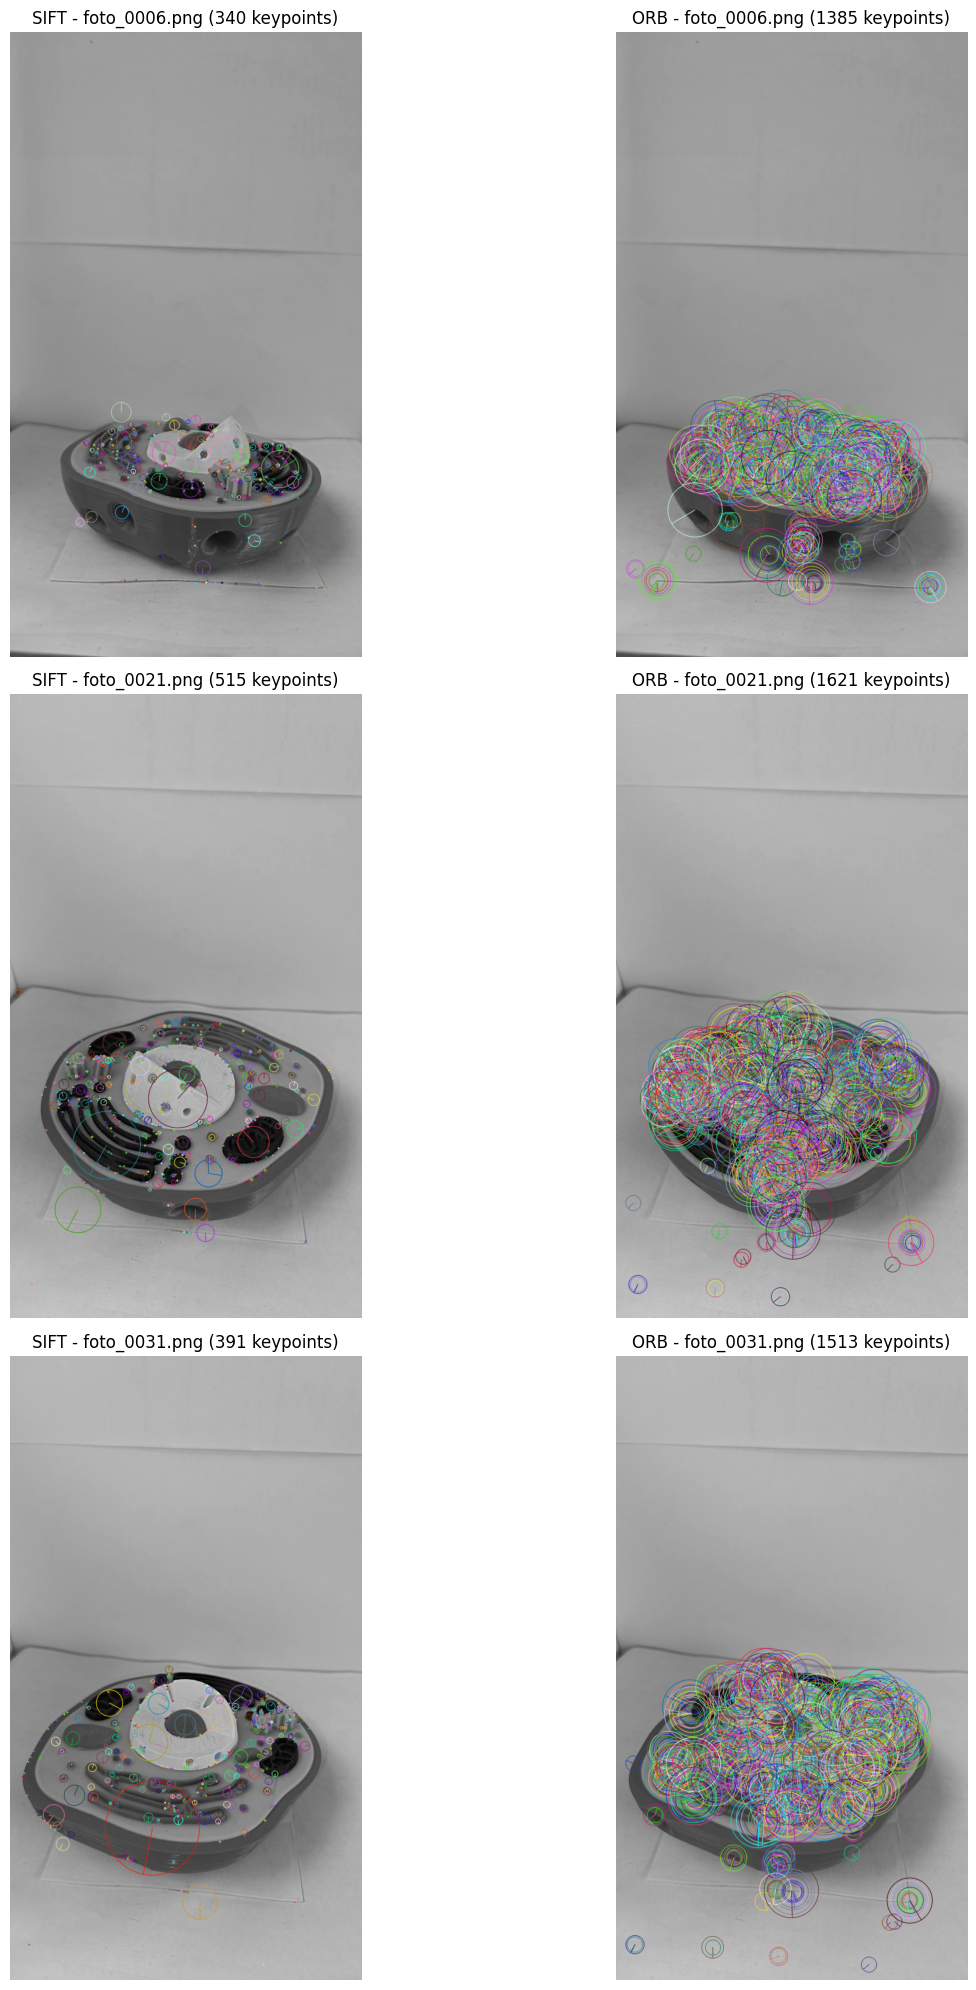

In [4]:
import matplotlib.pyplot as plt

# Select images at indices 5, 20, and 30
selected_indices = [5, 20, 30]
selected_images = [max_png_images[i] for i in selected_indices]

# Apply SIFT and ORB to selected images
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

for i, image_path in enumerate(selected_images):
    # Load original image for display
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply SIFT
    keypoints_sift, descriptors_sift = detect_and_extract_sift(image_path)
    img_sift = cv2.drawKeypoints(img, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Apply ORB
    keypoints_orb, descriptors_orb = detect_and_extract_orb(image_path)
    img_orb = cv2.drawKeypoints(img, keypoints_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display SIFT results
    axes[i, 0].imshow(img_sift, cmap='gray')
    axes[i, 0].set_title(f'SIFT - {os.path.basename(image_path)} ({len(keypoints_sift)} keypoints)')
    axes[i, 0].axis('off')
    
    # Display ORB results
    axes[i, 1].imshow(img_orb, cmap='gray')
    axes[i, 1].set_title(f'ORB - {os.path.basename(image_path)} ({len(keypoints_orb)} keypoints)')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
def match_features_flann(descriptors1, descriptors2, ratio_threshold=0.75):
    """
    Matches features using FLANN matcher with Lowe's ratio test
    
    Args:
        descriptors1: First set of descriptors
        descriptors2: Second set of descriptors
        ratio_threshold: Ratio threshold for Lowe's test (default 0.75)
    
    Returns:
        good_matches: List of good matches after ratio test
    """
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    # Create FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Find matches using k-nearest neighbor (k=2)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_threshold * n.distance:
                good_matches.append(m)
    
    return good_matches

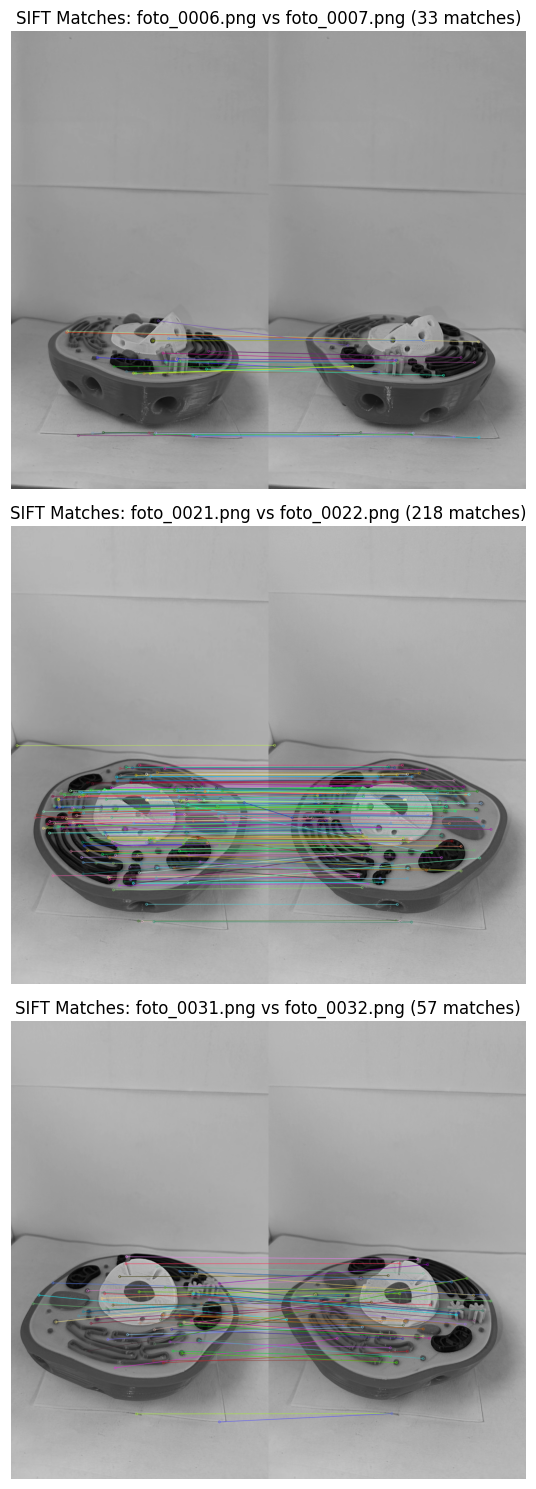

In [6]:
# Select 3 pairs of images for matching
pair_indices = [(5, 6), (20, 21), (30, 31)]

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for i, (idx1, idx2) in enumerate(pair_indices):
    # Get image paths
    img1_path = max_png_images[idx1]
    img2_path = max_png_images[idx2]
    
    # Load images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
    
    # Extract SIFT features from both images
    keypoints1, descriptors1 = detect_and_extract_sift(img1_path)
    keypoints2, descriptors2 = detect_and_extract_sift(img2_path)
    
    # Match features using FLANN
    good_matches = match_features_flann(descriptors1, descriptors2)
    
    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, 
                                 good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display results
    axes[i].imshow(img_matches, cmap='gray')
    axes[i].set_title(f'SIFT Matches: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)} ({len(good_matches)} matches)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
import numpy as np

def estimate_fundamental_matrix_ransac(kp1, kp2, matches, threshold=1.0, max_iterations=1000):
    """
    Estimate fundamental matrix using RANSAC
    """
    if len(matches) < 8:
        return None, []
    
    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, threshold, 0.99, max_iterations)
    
    # Get inlier matches
    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i]]
    
    return F, inlier_matches

def recover_pose_from_fundamental(F, kp1, kp2, matches, K):
    """
    Recover camera pose from fundamental matrix
    K: camera intrinsic matrix
    """
    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Compute essential matrix from fundamental matrix
    E = K.T @ F @ K
    
    # Recover pose from essential matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    
    return R, t, mask

def triangulate_points(kp1, kp2, matches, K, R, t):
    """
    Triangulate 3D points from matched keypoints
    """
    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
    
    # Camera projection matrices
    P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])  # First camera at origin
    P2 = K @ np.hstack([R, t])  # Second camera with pose R,t
    
    # Triangulate points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert from homogeneous to 3D coordinates
    points_3d = points_4d[:3] / points_4d[3]
    
    return points_3d.T

# Camera intrinsic matrix (assumed values - adjust based on your camera)
K = np.array([[949.97226758, 0, 630.81760602],
              [0, 949.47553139, 356.35824094],
              [0, 0, 1]], dtype=np.float32)

# Process the last pair of images (clean_030 and clean_031) - índices 30 e 31
print("Processing fundamental matrix estimation and pose recovery...")
print("Using the last processed pair from the matching visualization...")

# Use the last pair from the previous cell
img1_path = max_png_images[30]
img2_path = max_png_images[31]

print(f"Processing: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")

# Extract SIFT features from both images
keypoints1, descriptors1 = detect_and_extract_sift(img1_path)
keypoints2, descriptors2 = detect_and_extract_sift(img2_path)

# Match features using FLANN (without quantity filtering)
all_matches = match_features_flann(descriptors1, descriptors2)
print(f"Found {len(all_matches)} matches after ratio test")

# Estimate fundamental matrix with RANSAC using ALL matches
F, inlier_matches = estimate_fundamental_matrix_ransac(keypoints1, keypoints2, all_matches)

if F is not None:
    print(f"Fundamental matrix estimated with {len(inlier_matches)} inliers out of {len(all_matches)} matches")
    print(f"Inlier ratio: {len(inlier_matches)/len(all_matches)*100:.1f}%")
    print("Fundamental Matrix F:")
    print(F)
    
    print(f"\nUsing all {len(inlier_matches)} inliers for pose estimation and triangulation")
    
    # Recover camera pose using all inliers
    R, t, pose_mask = recover_pose_from_fundamental(F, keypoints1, keypoints2, inlier_matches, K)
    
    print("\nRecovered Camera Pose:")
    print("Rotation matrix R:")
    print(R)
    print("Translation vector t:")
    print(t.flatten())
    
    # Triangulate 3D points using all inliers
    points_3d = triangulate_points(keypoints1, keypoints2, inlier_matches, K, R, t)
    
    print(f"\nTriangulated {points_3d.shape[0]} 3D points")
    print("Sample 3D points (first 5):")
    print(points_3d[:5])
    
    # Filter out points that are too far (likely outliers)
    distances = np.linalg.norm(points_3d, axis=1)
    valid_mask = distances < np.percentile(distances, 95)  # Keep 95% of closest points
    points_3d_filtered = points_3d[valid_mask]
    
    print(f"After filtering: {points_3d_filtered.shape[0]} valid 3D points")
    print("3D point statistics:")
    print(f"X range: [{points_3d_filtered[:,0].min():.2f}, {points_3d_filtered[:,0].max():.2f}]")
    print(f"Y range: [{points_3d_filtered[:,1].min():.2f}, {points_3d_filtered[:,1].max():.2f}]")
    print(f"Z range: [{points_3d_filtered[:,2].min():.2f}, {points_3d_filtered[:,2].max():.2f}]")
    
else:
    print("Failed to estimate fundamental matrix")

Processing fundamental matrix estimation and pose recovery...
Using the last processed pair from the matching visualization...
Processing: foto_0031.png vs foto_0032.png
Found 57 matches after ratio test
Fundamental matrix estimated with 21 inliers out of 57 matches
Inlier ratio: 36.8%
Fundamental Matrix F:
[[ 2.62910435e-07 -3.09013907e-07 -1.48822071e-03]
 [-1.17616203e-06  6.60856766e-07  6.77900786e-03]
 [ 4.35195620e-05 -7.46687230e-03  1.00000000e+00]]

Using all 21 inliers for pose estimation and triangulation

Recovered Camera Pose:
Rotation matrix R:
[[ 0.94628533 -0.25555955  0.19807422]
 [ 0.25626444  0.9663445   0.02251324]
 [-0.19716141  0.02945543  0.97992845]]
Translation vector t:
[-0.97490128 -0.22175539  0.01980024]

Triangulated 21 3D points
Sample 3D points (first 5):
[[-4.2733903  4.6598144  8.126588 ]
 [-3.957067   4.8087616  8.87936  ]
 [-5.517789   6.0848346 12.723499 ]
 [-3.878804   4.8936076  9.0477295]
 [-3.330086   4.5530534  7.8924513]]
After filtering: 19 

=== VISUALIZAÇÃO DAS CORRESPONDÊNCIAS INLIERS ===


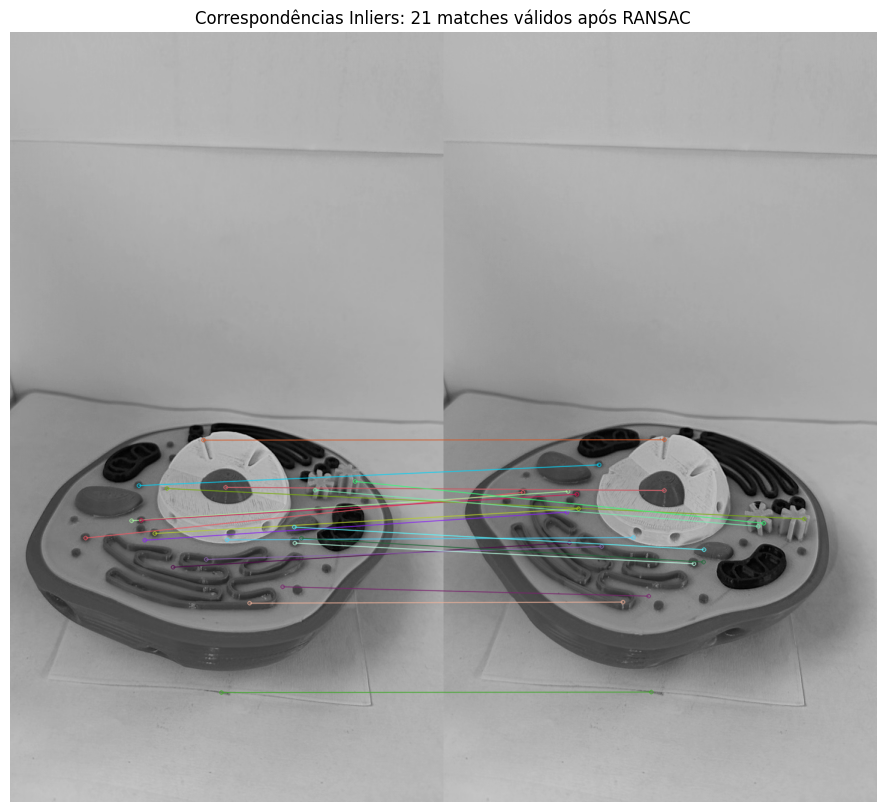


=== LINHAS EPIPOLARES (Amostra de 21 correspondências) ===


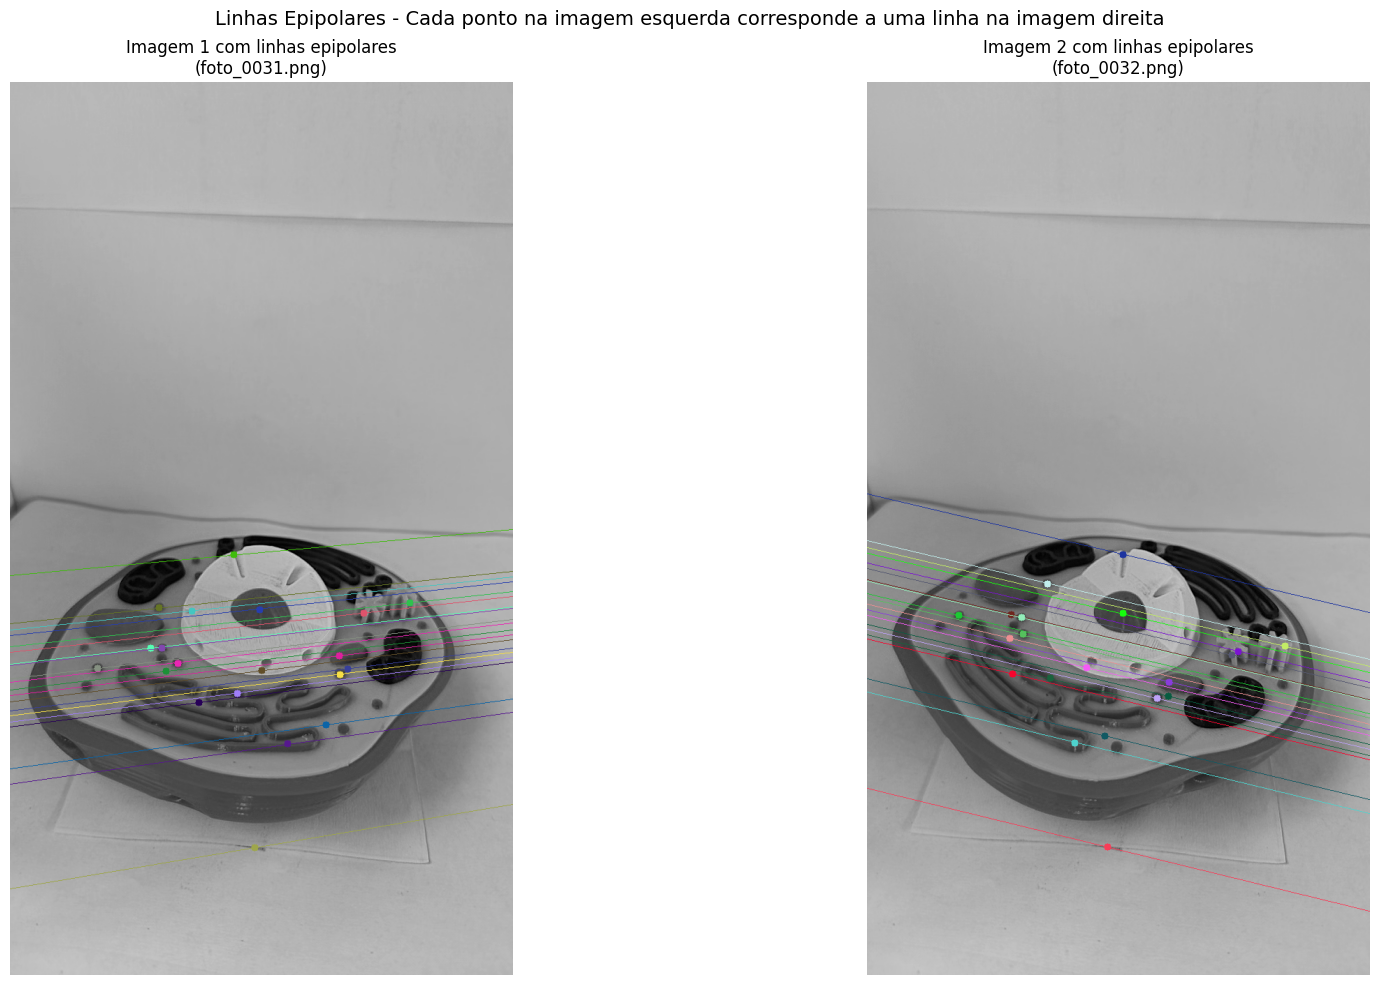


Interpretação das linhas epipolares:
- Cada ponto colorido representa uma correspondência inlier
- As linhas coloridas são as linhas epipolares correspondentes
- Um ponto na imagem esquerda deve estar na linha epipolar correspondente na imagem direita
- A qualidade da geometria epipolar pode ser avaliada pela proximidade dos pontos às suas linhas


In [8]:
def draw_epilines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines on images
    """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(map(int, pt1)), 5, color, -1)
        img2 = cv2.circle(img2, tuple(map(int, pt2)), 5, color, -1)
    
    return img1, img2

# Visualizar correspondências inliers
print("=== VISUALIZAÇÃO DAS CORRESPONDÊNCIAS INLIERS ===")

# Carregar as imagens para visualização
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# Desenhar correspondências inliers
img_inliers = cv2.drawMatches(img1, keypoints1, img2, keypoints2, 
                             inlier_matches, None, 
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Mostrar as correspondências inliers
plt.figure(figsize=(20, 10))
plt.imshow(img_inliers, cmap='gray')
plt.title(f'Correspondências Inliers: {len(inlier_matches)} matches válidos após RANSAC')
plt.axis('off')
plt.show()

# Selecionar uma amostra das correspondências para exibir linhas epipolares
n_sample = min(50, len(inlier_matches))  # Máximo 50 pontos para clareza visual
sample_matches = inlier_matches[:n_sample]

print(f"\n=== LINHAS EPIPOLARES (Amostra de {n_sample} correspondências) ===")

# Extrair pontos das correspondências amostradas
pts1_sample = np.float32([keypoints1[m.queryIdx].pt for m in sample_matches]).reshape(-1, 1, 2)
pts2_sample = np.float32([keypoints2[m.trainIdx].pt for m in sample_matches]).reshape(-1, 1, 2)

# Calcular linhas epipolares para pontos na imagem 1 -> linhas na imagem 2
lines1 = cv2.computeCorrespondEpilines(pts2_sample, 2, F)
lines1 = lines1.reshape(-1, 3)

# Calcular linhas epipolares para pontos na imagem 2 -> linhas na imagem 1
lines2 = cv2.computeCorrespondEpilines(pts1_sample, 1, F)
lines2 = lines2.reshape(-1, 3)

# Desenhar linhas epipolares
img1_epi, img2_epi = draw_epilines(img1, img2, lines1, pts1_sample.squeeze(), pts2_sample.squeeze())
img2_epi, img1_epi_alt = draw_epilines(img2, img1, lines2, pts2_sample.squeeze(), pts1_sample.squeeze())

# Visualizar linhas epipolares
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(cv2.cvtColor(img1_epi, cv2.COLOR_BGR2RGB))
ax1.set_title(f'Imagem 1 com linhas epipolares\n({os.path.basename(img1_path)})')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(img2_epi, cv2.COLOR_BGR2RGB))
ax2.set_title(f'Imagem 2 com linhas epipolares\n({os.path.basename(img2_path)})')
ax2.axis('off')

plt.suptitle('Linhas Epipolares - Cada ponto na imagem esquerda corresponde a uma linha na imagem direita', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nInterpretação das linhas epipolares:")
print(f"- Cada ponto colorido representa uma correspondência inlier")
print(f"- As linhas coloridas são as linhas epipolares correspondentes")
print(f"- Um ponto na imagem esquerda deve estar na linha epipolar correspondente na imagem direita")
print(f"- A qualidade da geometria epipolar pode ser avaliada pela proximidade dos pontos às suas linhas")